# 1.3.1 Clipped Inverse Propensity Score(CIPS)推定量
参考文献
- Yi Su, Maria Dimakopoulou, Akshay Krishnamurthy, and Miroslav Dudík. [Doubly Robust Off-Policy Evaluation with Shrinkage](https://arxiv.org/abs/1907.09623). ICML2021.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
from sklearn.utils import check_random_state
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.style.use('ggplot')
linestyle_dict = {"se": "-", "bias": "--", "variance": "dotted"}
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

# import open bandit pipeline (obp)
import obp
from obp.dataset import (
    SyntheticBanditDatasetWithActionEmbeds as SyntheticBanditDataset,
    logistic_polynomial_reward_function,
)
from obp.ope import OffPolicyEvaluation, InverseProbabilityWeighting as IPS
from utils import eps_greedy_policy, aggregate_simulation_results, aggregate_simulation_results_lam

In [2]:
print(obp.__version__)


0.5.5


### ハイパーパラメータの値$\lambda$を変化させたときのCIPS推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [3]:
## シミュレーション設定
num_runs = 500 # シミュレーションの繰り返し回数
dim_context = 10 # 特徴量xの次元
n_actions = 100 # 行動数, |A|
beta = -5 # データ収集方策のパラメータ
random_state = 12345
test_data_size = 100000 # 評価方策の真の性能を近似するためのテストデータのサイズ
random_ = check_random_state(random_state)
num_data_list = [250, 500, 1000, 2000, 4000, 8000]

In [4]:
result_df_list = []
for num_data in [250, 500, 2000]:
    ## 人工データ生成クラス
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        action_context=random_.normal(size=(n_actions, 10)),
        beta=beta,
        reward_function=logistic_polynomial_reward_function,
        random_state=random_state,
    )

    ## 評価方策の真の性能(policy value)を近似するためのテストデータ
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_data_size)

    ## 評価方策の真の性能(policy value)を近似
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_data["expected_reward"],
        action_dist=eps_greedy_policy(test_data["expected_reward"]),
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=num_data
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["expected_reward"])

        ## ログデータを用いてオフ方策評価を実行する
        ope = OffPolicyEvaluation(
            bandit_feedback=offline_logged_data,
            ope_estimators=[IPS(lambda_=lam, estimator_name=lam) for lam in range(0, 500)]
        )
        estimated_policy_values = ope.estimate_policy_values(action_dist=pi)
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results_lam(
            estimated_policy_value_list, policy_value, "num_data", num_data,
        )
    )
result_df = pd.concat(result_df_list).reset_index(level=0)
result_df = result_df.groupby(["lam", "num_data"]).mean().reset_index()


num_data=2000...: 100%|██████████| 500/500 [02:53<00:00,  2.88it/s]


## 図1.21

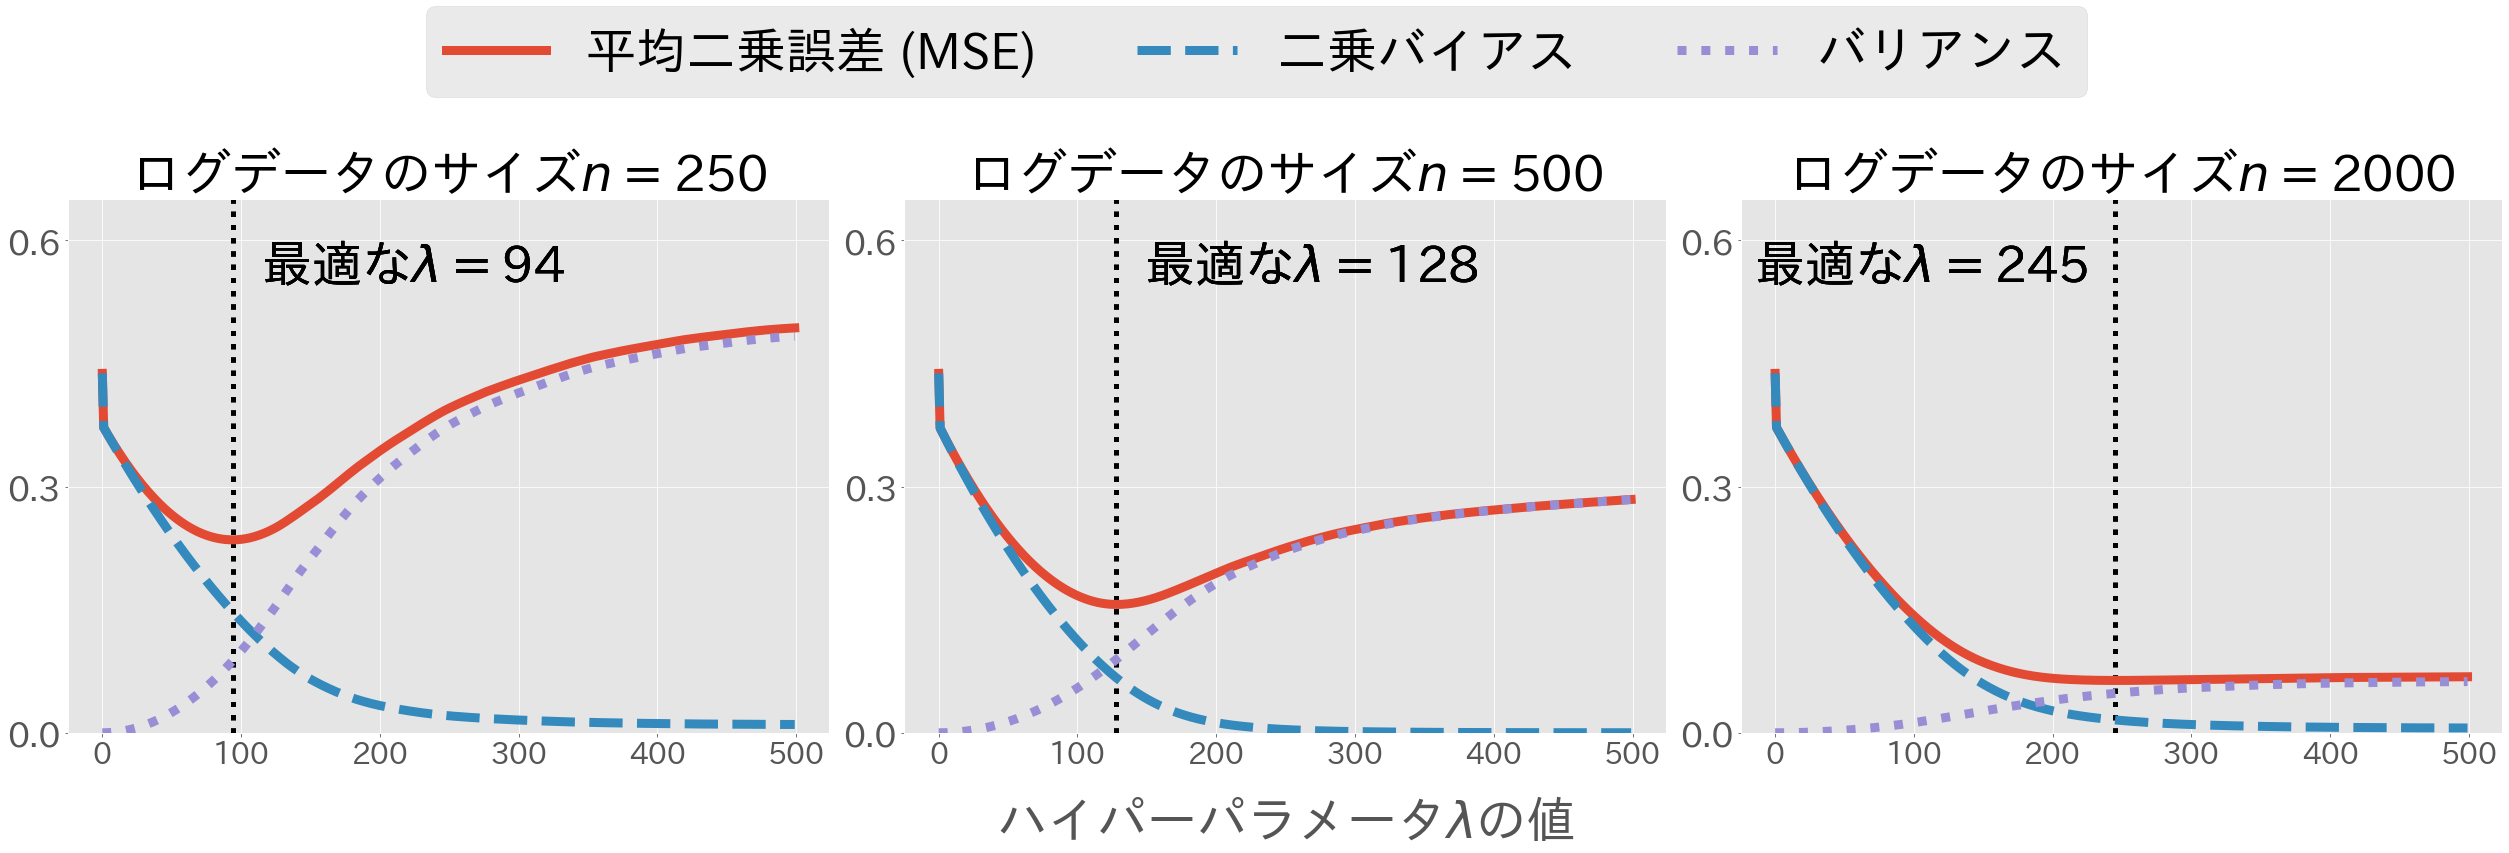

In [5]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, num_data in enumerate([250, 500, 2000]):
    ax = ax_list[i]
    result_df_ = result_df.query(f"num_data == {num_data}").reset_index()
    optimal_hyperparam_index = result_df_.se.argmin()
    optimal_hyperparam = result_df_.loc[optimal_hyperparam_index, "lam"]
    for y in ["se", "bias", "variance"]:
        sns.lineplot(
            linewidth=9,
            legend=False,
            linestyle=linestyle_dict[y],
            x="lam",
            y=y,
            ax=ax,
            data=result_df_,
        )
        ax.set_title(f"ログデータのサイズ$n=${num_data}", fontsize=50)
        # yaxis
        ax.set_ylabel("")
        ax.set_ylim(0.0, 0.65)
        ax.tick_params(axis="y", labelsize=35)
        ax.set_yticks([0.0, 0.3, 0.6])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        # xaxis
        if i == 1:
            ax.set_xlabel(r"ハイパーパラメータ$\lambda$の値", fontsize=50)
        else:
            ax.set_xlabel(r"", fontsize=40)
        ax.set_xticks([0, 100, 200, 300, 400, 500])
        ax.set_xticklabels([0, 100, 200, 300, 400, 500], fontsize=30)
        ax.xaxis.set_label_coords(0.5, -0.12)
        ax.vlines(optimal_hyperparam, 0, 0.65, color='black', linewidth=5, linestyles='dotted')
        if num_data > 500:
            ax.text(optimal_hyperparam-260, 0.55, f"最適な$\lambda=${optimal_hyperparam}", fontsize=50)
        else:
            ax.text(optimal_hyperparam+20, 0.55, f"最適な$\lambda=${optimal_hyperparam}", fontsize=50)
fig.legend(
    ["平均二乗誤差 (MSE)", "二乗バイアス", "バリアンス"],
    fontsize=50, bbox_to_anchor=(0.5, 1.12), ncol=4, loc="center",
)


### (データ収集方策が収集した)ログデータのサイズ$n$を変化させたときのCIPS推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [6]:
result_df_list = []
for num_data in num_data_list:
    ## 人工データ生成クラス
    dataset = SyntheticBanditDataset(
        n_actions=n_actions,
        dim_context=dim_context,
        action_context=random_.normal(size=(n_actions, 10)),
        beta=beta,
        reward_function=logistic_polynomial_reward_function,
        random_state=random_state,
    )

    ## 評価方策の真の性能(policy value)を近似するためのテストデータ
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_data_size)

    ## 評価方策の真の性能(policy value)を近似
    policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=test_data["expected_reward"],
        action_dist=eps_greedy_policy(test_data["expected_reward"]),
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=num_data
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["expected_reward"])

        ## ログデータを用いてオフ方策評価を実行する
        ope = OffPolicyEvaluation(
            bandit_feedback=offline_logged_data,
            ope_estimators=[
                IPS(lambda_=50, estimator_name="50"),
                IPS(lambda_=150, estimator_name="150"),
                IPS(estimator_name="infty")
            ]
        )
        estimated_policy_values = ope.estimate_policy_values(action_dist=pi)
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_data", num_data,
        )
    )
result_df = pd.concat(result_df_list).reset_index(level=0)


num_data=8000...: 100%|██████████| 500/500 [03:12<00:00,  2.59it/s]


## 図1.22

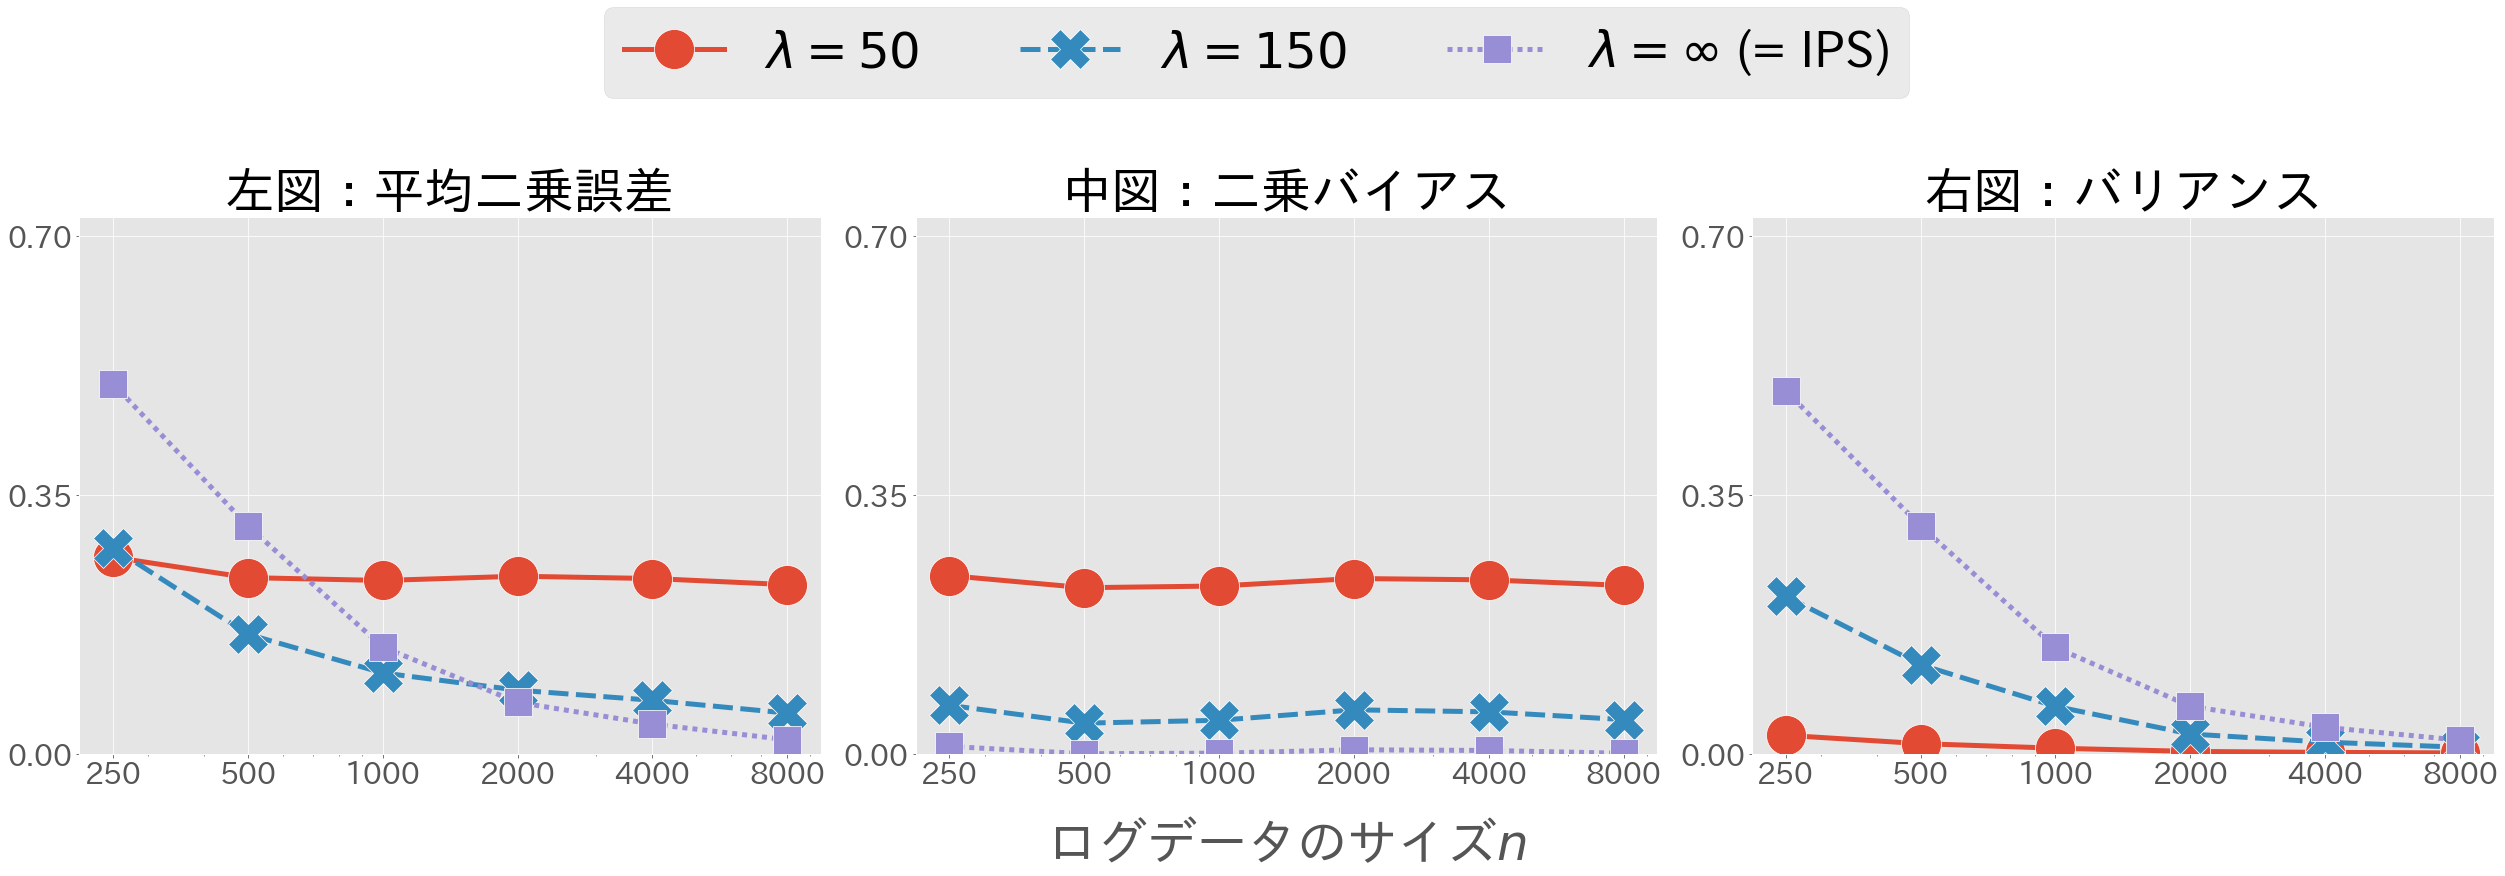

In [7]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=5,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        data=result_df,
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 0.725)
    ax.tick_params(axis="y", labelsize=30)
    ax.set_yticks([0.0, 0.35, 0.7])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(
    [r"$\lambda=50$", r"$\lambda=150$", r"$\lambda=\infty$ (= IPS)"],
    fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=4, loc="center",
)
